#### idea: semi supervised bidirectional LSTM 

In [3]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull
import pandas as pd
from tensorflow import keras
from sklearn.manifold import TSNE
import os
from collections import Counter

In [20]:

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn


### fasta stuff

In [21]:
def read_fasta(input_f):
    sequences = []
    current_seq = ""
    with open(input_f, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                if current_seq:
                    sequences.append(current_seq)
                    current_seq = ""
            else:
                current_seq += line
        if current_seq:
            sequences.append(current_seq)
    return sequences

def select_random_sequences(sequences, num_samples=10000):
    if len(sequences) < num_samples :
        raise ValueError("The number of requested sequences exceeds the initial list size.")

    return random.sample(sequences, num_samples)


def encode_sequences_one_hot_with_gap(sequences, max_length=None) :

    amino_acids = '-ACDEFGHIKLMNPQRSTVWY'
    aa_to_idx = {aa: idx for idx, aa in enumerate(amino_acids)}
    valid_sequences = [seq for seq in sequences if all(aa in aa_to_idx for aa in seq)]

    if not valid_sequences :  # Return empty array if no valid sequences remain
        return np.array([])

    # Set maximum length
    if max_length is None :
        max_length = max(len(seq) for seq in valid_sequences)

    # Initialize the output matrix with zeros
    M = len(valid_sequences)
    L = max_length
    encoded_matrix = np.zeros((M, L, len(amino_acids)), dtype=np.float32)

    # Encode each sequence
    for i, seq in enumerate(valid_sequences) :
        for j, aa in enumerate(seq[:max_length]) :  # Truncate sequences longer than max_length
            encoded_matrix[i, j, aa_to_idx[aa]] = 1.0  # One-hot encode valid amino acids and gaps
    return encoded_matrix

##### preparing data: getting labled sequence, split them for training/val/test (without flattening them cuz encoder would do it)

In [4]:
# 1) Path to your labeled-folder
data_dir = "hmm_20"

# 2) Find all .fasta files in there
fasta_files = [f for f in os.listdir(data_dir) if f.lower().endswith('.fasta')]

# 3) Read & count
label_counts = {}
all_seqs     = []
all_labels   = []

suffix = "_noInserts_noGaps_noDuplicates"

for fname in fasta_files:
    # strip extension
    base = os.path.splitext(fname)[0]
    # remove the unwanted suffix if present
    if base.endswith(suffix):
        label = base[:-len(suffix)]
    else:
        label = base

    path  = os.path.join(data_dir, fname)
    seqs  = read_fasta(path)                # your existing FASTA reader
    n     = len(seqs)

    label_counts[label] = n
    all_seqs.extend(seqs)
    all_labels.extend([label] * n)

# 4) Print summary
print(f"Found {len(label_counts)} classes, {sum(label_counts.values())} total sequences\n")
for lbl, cnt in label_counts.items():
    print(f"  {lbl:30s} : {cnt}")

# 5) Map labels → integer IDs
unique_labels = sorted(label_counts.keys())
label_to_idx  = {lbl:i for i,lbl in enumerate(unique_labels)}
y_labels      = np.array([label_to_idx[lbl] for lbl in all_labels], dtype=np.int32)

print("\nLabel → index mapping:")
for lbl, idx in label_to_idx.items():
    print(f"  {lbl:30s} → {idx}")

print(f"\nall_seqs  length: {len(all_seqs)}")
print(f"y_labels  shape : {y_labels.shape}")

# 0) your amino‑acid map (same as in your encoder)
amino_acids = '-ACDEFGHIKLMNPQRSTVWY'
aa_to_idx   = {aa: i for i, aa in enumerate(amino_acids)}

# 1) Build a mask of “valid” sequences (only drop those that truly have bad chars)
valid_idxs = [
    i for i, seq in enumerate(all_seqs)
    if all(aa in aa_to_idx for aa in seq)
]

# 2) Filter both sequences *and* labels
filtered_seqs   = [all_seqs[i]    for i in valid_idxs]
filtered_labels = [y_labels[i]     for i in valid_idxs]

# 3) Now one‑hot encode the filtered list
X_lab_onehot = encode_sequences_one_hot_with_gap(filtered_seqs, max_length=263)
y_lab = np.array(filtered_labels, dtype=np.int32)

print("After filtering:", X_lab_onehot.shape, y_lab.shape)


Found 15 classes, 1758 total sequences

  aurora_kinases                 : 32
  calcium_calmodulin_dependent_kinases : 32
  calcium_dependent_kinases      : 80
  cAMP_dependent_protein_kinases : 27
  casein_kinases                 : 31
  CBL_interacting_protein_kinases : 31
  cyclin_dependent_kinases       : 172
  dual_specificity_protein_kinases : 17
  eukaryotic_translation_initiation_factor_kinases : 8
  L_type_lectin_kinases          : 12
  mitogen_activated_kinases      : 255
  protein_kinases                : 78
  ribosomal_protein_S6_kinases   : 23
  serine_threonine_kinases       : 944
  tyrosine_kinases               : 16

Label → index mapping:
  CBL_interacting_protein_kinases → 0
  L_type_lectin_kinases          → 1
  aurora_kinases                 → 2
  cAMP_dependent_protein_kinases → 3
  calcium_calmodulin_dependent_kinases → 4
  calcium_dependent_kinases      → 5
  casein_kinases                 → 6
  cyclin_dependent_kinases       → 7
  dual_specificity_protein_kinases

In [13]:
unique_labels = sorted(set(all_labels))
num_classes   = len(unique_labels)   # should be 15


In [5]:
# starting from X_lab_onehot (N,263,21) and y_lab (N,)
# a) carve off test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_lab_onehot, y_lab,
    test_size=0.2,
    random_state=42,
    stratify=y_lab
)


# b) split remaining 80% into train (60% total) and val (20% total)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,   # 0.25 * 0.8 = 0.2 overall
    random_state=42,
    stratify=y_temp
)

print(
    "Shapes:",
    X_tr.shape, X_val.shape, X_test.shape,
    y_tr.shape, y_val.shape, y_test.shape
)

Shapes: (1053, 263, 21) (352, 263, 21) (352, 263, 21) (1053,) (352,) (352,)


In [ ]:
### ProDec-BLSTM model (tailored to 15 classes and sequence length 263)

In [26]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, TimeDistributed, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# Assuming your data is already loaded
# X_tr, X_val, X_test: (N, 263, 21)
# y_tr, y_val, y_test: (N,) with class indices

num_classes = 15
y_tr_cat = to_categorical(y_tr, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# === Model ===
input_layer = Input(shape=(263, 21))
x = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
x = TimeDistributed(Dense(64, activation='relu'))(x)
x = GlobalMaxPooling1D()(x)
output_layer = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# === Callbacks: Early stopping + save best ===
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model_keras.h5', save_best_only=True)
]

# === Train ===
model.fit(
    X_tr, y_tr_cat,
    validation_data=(X_val, y_val_cat),
    batch_size=64,
    epochs=50,
    callbacks=callbacks
)

# === Evaluate ===
test_loss, test_acc = model.evaluate(X_test, y_test_cat)
print(f"Test accuracy: {test_acc:.4f}")


Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 941ms/step - accuracy: 0.3755 - loss: 2.4091

17/17 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.3811 - loss: 2.3939 - val_accuracy: 0.5369 - val_loss: 1.7399
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 944ms/step - accuracy: 0.5414 - loss: 1.7154

17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 990ms/step - accuracy: 0.5412 - loss: 1.7140 - val_accuracy: 0.5369 - val_loss: 1.6435
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 987ms/step - accuracy: 0.5515 - loss: 1.6557

17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5507 - loss: 1.6552 - val_accuracy: 0.5369 - val_loss: 1.6127
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5498 - loss: 1.5988

17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5491 - loss: 1.5999 - val_accuracy: 0.5369 - val_loss: 1.5799
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5192 - loss: 1.6183

17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5202 - loss: 1.6163 - val_accuracy: 0.5369 - val_loss: 1.5548
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5336 - loss: 1.5841

17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5345 - loss: 1.5809 - val_accuracy: 0.5398 - val_loss: 1.4522
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5772 - loss: 1.4328

17/17 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.5778 - loss: 1.4320 - val_accuracy: 0.5710 - val_loss: 1.3920
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 991ms/step - accuracy: 0.5936 - loss: 1.4134

17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5949 - loss: 1.4122 - val_accuracy: 0.6307 - val_loss: 1.2964
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 986ms/step - accuracy: 0.6363 - loss: 1.3106

17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6372 - loss: 1.3087 - val_accuracy: 0.6165 - val_loss: 1.2315
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6397 - loss: 1.1955

17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6401 - loss: 1.1957 - val_accuracy: 0.6562 - val_loss: 1.1975
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6797 - loss: 1.1219

17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6790 - loss: 1.1222 - val_accuracy: 0.6619 - val_loss: 1.1130
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6479 - loss: 1.0838

17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6496 - loss: 1.0814 - val_accuracy: 0.6676 - val_loss: 1.0529
Epoch 13/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7061 - loss: 0.9979

17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7066 - loss: 0.9975 - val_accuracy: 0.7273 - val_loss: 0.9646
Epoch 14/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 998ms/step - accuracy: 0.7270 - loss: 0.8942

17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7278 - loss: 0.8924 - val_accuracy: 0.7188 - val_loss: 0.9211
Epoch 15/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7519 - loss: 0.8156

17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7524 - loss: 0.8142 - val_accuracy: 0.7699 - val_loss: 0.8544
Epoch 16/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7967 - loss: 0.7237

17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7957 - loss: 0.7244 - val_accuracy: 0.7727 - val_loss: 0.7878
Epoch 17/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8068 - loss: 0.6676

17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8066 - loss: 0.6680 - val_accuracy: 0.7784 - val_loss: 0.7289
Epoch 18/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8113 - loss: 0.5802

17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8119 - loss: 0.5800 - val_accuracy: 0.7841 - val_loss: 0.7037
Epoch 19/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8043 - loss: 0.6003

17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8045 - loss: 0.6004 - val_accuracy: 0.8239 - val_loss: 0.6470
Epoch 20/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8388 - loss: 0.5281

17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8387 - loss: 0.5272 - val_accuracy: 0.8097 - val_loss: 0.6372
Epoch 21/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8629 - loss: 0.4538

17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8631 - loss: 0.4527 - val_accuracy: 0.8097 - val_loss: 0.6249
Epoch 22/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8894 - loss: 0.3792

17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8890 - loss: 0.3798 - val_accuracy: 0.8210 - val_loss: 0.5595
Epoch 23/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8983 - loss: 0.3576

17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8975 - loss: 0.3583 - val_accuracy: 0.8438 - val_loss: 0.5284
Epoch 24/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9144 - loss: 0.3380 - val_accuracy: 0.8239 - val_loss: 0.5302
Epoch 25/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9012 - loss: 0.2934 - val_accuracy: 0.8324 - val_loss: 0.5523
Epoch 26/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9247 - loss: 0.2859 - val_accuracy: 0.8381 - val_loss: 0.5698
Epoch 27/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9203 - loss: 0.2616 - val_accuracy: 0.8352 - val_loss: 0.5416
Epoch 28/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9330 - loss: 0.2434 - val_accuracy: 0.8409 - val_loss: 0.5896
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.8353 - loss: 0.5139
Test accuracy: 0.8295


In [28]:
print(f"Test set size: {len(X_test)} sequences")
from sklearn.metrics import classification_report

y_pred_probs = model.predict(X_test)  # shape (N_test, 15)
y_pred = y_pred_probs.argmax(axis=1)

print(classification_report(y_test, y_pred, target_names=unique_labels))


Test set size: 352 sequences
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step
                                                  precision    recall  f1-score   support

                 CBL_interacting_protein_kinases       0.29      0.33      0.31         6
                           L_type_lectin_kinases       1.00      0.50      0.67         2
                                  aurora_kinases       0.62      0.83      0.71         6
                  cAMP_dependent_protein_kinases       1.00      0.60      0.75         5
            calcium_calmodulin_dependent_kinases       0.75      0.86      0.80         7
                       calcium_dependent_kinases       0.94      0.94      0.94        16
                                  casein_kinases       1.00      0.83      0.91         6
                        cyclin_dependent_kinases       0.86      0.91      0.89        35
                dual_specificity_protein_kinases       1.00      0.33      0.50         3
eukaryotic_translation_initiat

c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


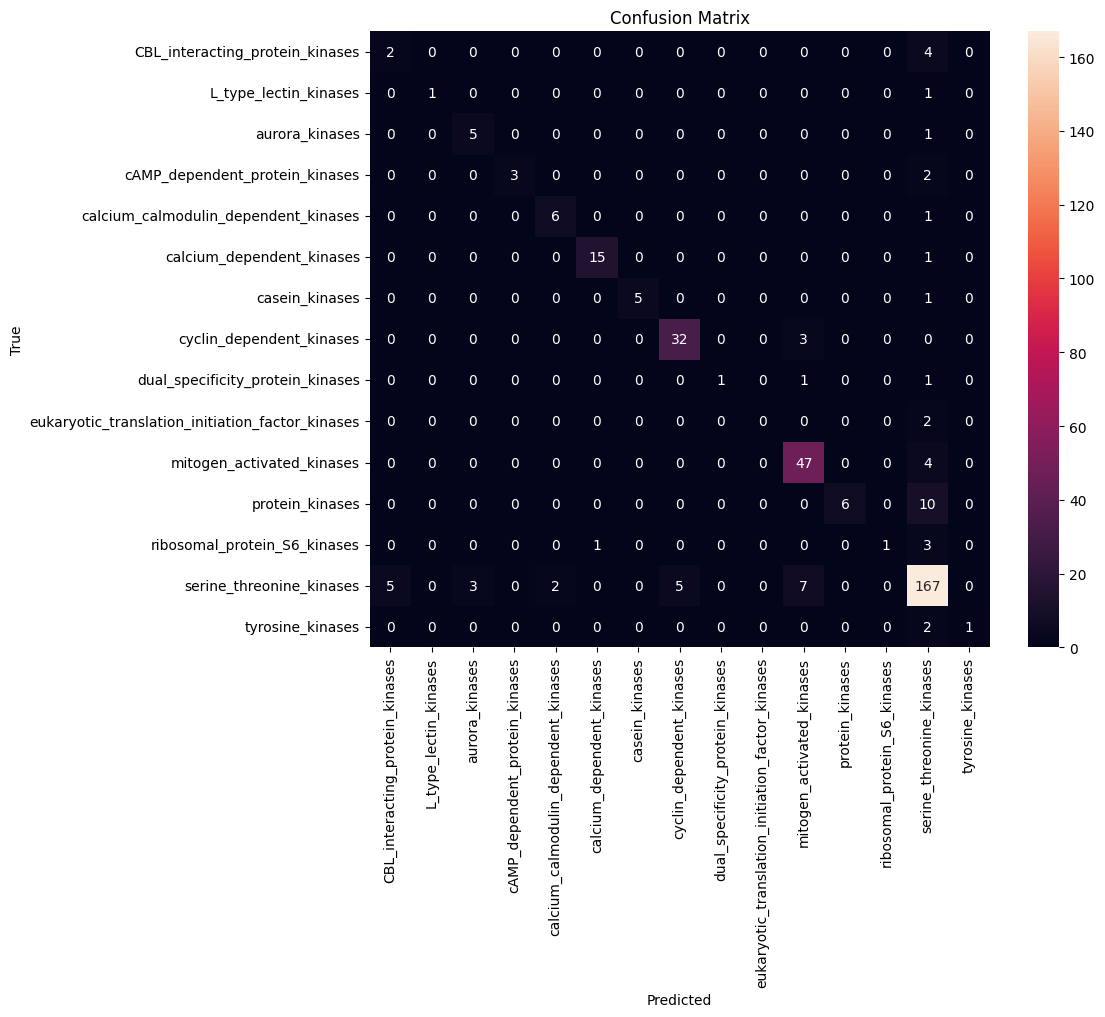

In [29]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


### experiment idea: making 15k artificial sequence out of one sequence from each class in test data, i will save them for testing the model on them.

Generate 1000 synthetic protein sequences per class (15 classes total) by:

Selecting 1 test sequence per class

Passing that sequence through your trained VAE encoder

Sampling from the latent space around that sequence

Decoding each latent sample into a new sequence

Preserve the label of each group

Concatenate and store the resulting (X, y) as .npz

When loading later, you can still shuffle if needed — the labels are intact

##### vae model shit

In [30]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a sequence."""
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class Encoder(layers.Layer):
    """Encodes sequences into latent space."""
    
    def __init__(self, latent_dim, intermediate_dims=[256, 128, 64], **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.dense_layers = []
        for dim in intermediate_dims:
            self.dense_layers.append(layers.Dense(dim, activation='relu'))
            self.dense_layers.append(layers.BatchNormalization())
            self.dense_layers.append(layers.Dropout(0.3))
        
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)
        self.sampling = Sampling()
    
    def call(self, inputs):
        x = inputs
        for layer in self.dense_layers:
            x = layer(x)
        
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling([z_mean, z_log_var])
        
        return z_mean, z_log_var, z

class Decoder(layers.Layer):
    """Decodes a latent space point into a sequence."""
    
    def __init__(self, original_dim, intermediate_dims=[64, 128, 256], **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.dense_layers = []
        for dim in intermediate_dims:
            self.dense_layers.append(layers.Dense(dim, activation='relu'))
            self.dense_layers.append(layers.BatchNormalization())
            self.dense_layers.append(layers.Dropout(0.3))
        
        self.dense_output = layers.Dense(original_dim, activation='sigmoid')
    
    def call(self, inputs):
        x = inputs
        for layer in self.dense_layers:
            x = layer(x)
        
        return self.dense_output(x)

class VAE(Model):
    """Variational Autoencoder for protein sequences."""
    
    def __init__(self, original_dim, latent_dim, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.original_dim = original_dim
        self.latent_dim = latent_dim
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(original_dim)
        
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        
        # Add KL divergence regularization loss
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        
        # Scale KL loss by input dimension to balance it with reconstruction loss
        kl_loss = kl_loss * (1.0 / self.original_dim)
        
        self.add_loss(kl_loss)
        return reconstructed
    
    def encode(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return z_mean, z_log_var, z
    
    def decode(self, z):
        return self.decoder(z)
    
    def get_config(self):
        config = super(VAE, self).get_config()
        config.update({
            'original_dim': self.original_dim,
            'latent_dim': self.latent_dim
        })
        return config
    

# Rebuild the model architecture
vae = VAE(original_dim=5523, latent_dim=32)

dummy_input = np.zeros((1, 5523), dtype=np.float32)  # Match input shape
_ = vae(dummy_input)  # Force layer creation

vae.load_weights('models/200000seq_best_vae_model.h5')  # Load weights

vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Encoder)               │ ?                      │     1,461,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Decoder)               │ ?                      │     1,464,659 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,925,907 (11.16 MB)

 Trainable params: 2,924,115 (11.15 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [31]:
import numpy as np
from collections import defaultdict
import random
import os

# Assumes: vae, X_test, y_test, unique_labels are defined

samples_by_class = defaultdict(list)
for x, y in zip(X_test, y_test):
    samples_by_class[y].append(x.reshape(-1))  # (5523,)

N_per_class = 1000
synthetic_data = []
synthetic_labels = []

for class_id in range(15):
    base_seq = random.choice(samples_by_class[class_id])
    base_seq = base_seq[np.newaxis, :]  # (1, 5523)

    z_mean, z_log_var, _ = vae.encode(base_seq)
    z_mean = z_mean.numpy()[0]
    z_log_var = z_log_var.numpy()[0]

    epsilon = np.random.normal(size=(N_per_class, vae.latent_dim))
    z_samples = z_mean + np.exp(0.5 * z_log_var) * epsilon

    recon_flat = vae.decode(z_samples).numpy()
    X_prob = recon_flat.reshape(N_per_class, 263, 21)

    # Convert probabilities to one-hot encoded sequences
    onehot = np.zeros_like(X_prob)
    onehot[np.arange(N_per_class)[:, None], np.arange(263), np.argmax(X_prob, axis=2)] = 1

    synthetic_data.append(onehot)
    synthetic_labels.extend([class_id] * N_per_class)

# Stack into final dataset (but don't shuffle)
X_syn = np.vstack(synthetic_data)  # (15000, 263, 21)
y_syn = np.array(synthetic_labels) # (15000,)

# Save to disk
save_dir = 'vae_generated_testseed_15class_1000each'
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, 'synthetic_15k_sequences_byclass.npz')

np.savez_compressed(save_path, X=X_syn, y=y_syn)
print(f"Saved synthetic data to: {save_path}")


Saved synthetic data to: vae_generated_testseed_15class_1000each\synthetic_15k_sequences_byclass.npz


##### for loading

In [32]:
data = np.load('vae_generated_testseed_15class_1000each/synthetic_15k_sequences_byclass.npz')
X_syn = data['X']  # shape (15000, 263, 21)
y_syn = data['y']  # shape (15000,)


In [37]:
print(X_syn[0])
print(y_syn[14999])

[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
14


lets project the 15k synth on 15k random natural seq

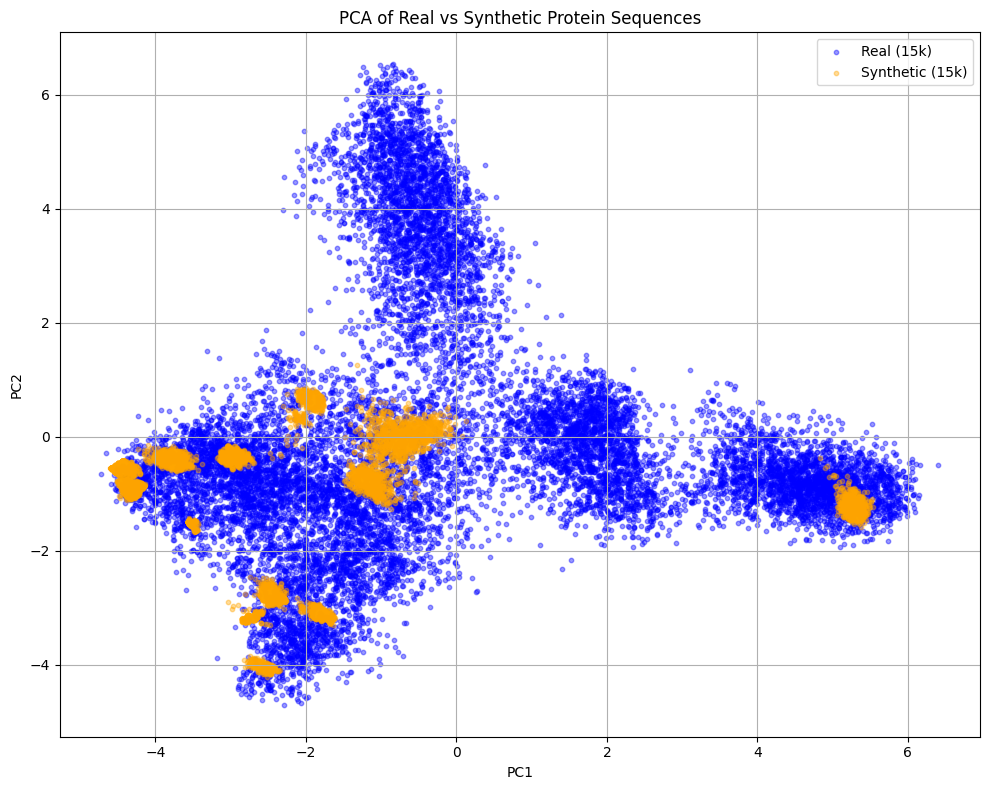

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

max_length = 263
unlabeled_fasta = 'PF00069_noinserts_gaps_noduplicates.fasta'

# Step 1: Load & sample real
all_real = read_fasta(unlabeled_fasta)
sel_idxs = np.random.choice(len(all_real), size=15000, replace=False)
real_seqs = [all_real[i] for i in sel_idxs]

# One-hot encode
X_real = encode_sequences_one_hot_with_gap(real_seqs, max_length)  # shape (15000, 263, 21)

# Step 2: Load synthetic data
data = np.load('vae_generated_testseed_15class_1000each/synthetic_15k_sequences_byclass.npz')
X_syn = data['X']  # shape (15000, 263, 21)

# Step 3: Flatten both
X_real_flat = X_real.reshape((X_real.shape[0], -1))  # (15000, 5523)
X_syn_flat  = X_syn.reshape((X_syn.shape[0], -1))    # (15000, 5523)

# Step 4: Fit PCA on real only
pca = PCA(n_components=2)
X_real_pca = pca.fit_transform(X_real_flat)
X_syn_pca  = pca.transform(X_syn_flat)

# Step 5: Plot
plt.figure(figsize=(10, 8))
plt.scatter(X_real_pca[:, 0], X_real_pca[:, 1], label='Real (15k)', alpha=0.4, s=10, c='blue')
plt.scatter(X_syn_pca[:, 0], X_syn_pca[:, 1], label='Synthetic (15k)', alpha=0.4, s=10, c='orange')
plt.legend()
plt.title("PCA of Real vs Synthetic Protein Sequences")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()


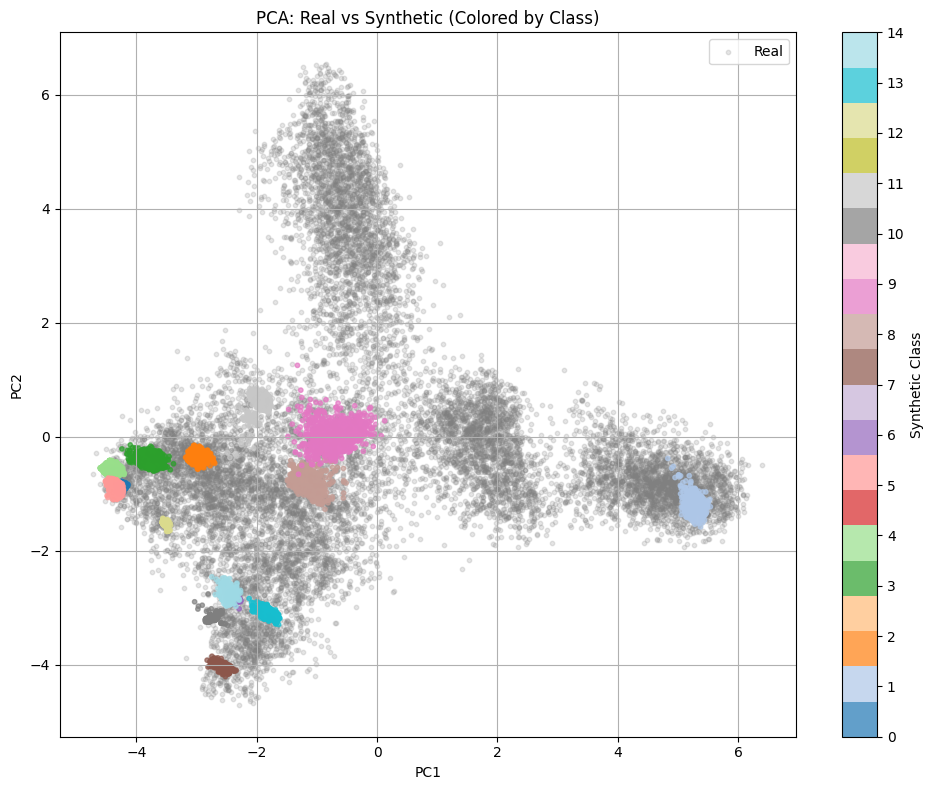

In [53]:
import matplotlib.pyplot as plt

y_syn = data['y']  # shape (15000,)

plt.figure(figsize=(10, 8))
plt.scatter(X_real_pca[:, 0], X_real_pca[:, 1], alpha=0.2, s=10, c='gray', label='Real')
scatter = plt.scatter(X_syn_pca[:, 0], X_syn_pca[:, 1], c=y_syn, cmap='tab20', s=10, alpha=0.7)
plt.colorbar(scatter, ticks=range(15), label='Synthetic Class')
plt.legend()
plt.title("PCA: Real vs Synthetic (Colored by Class)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()


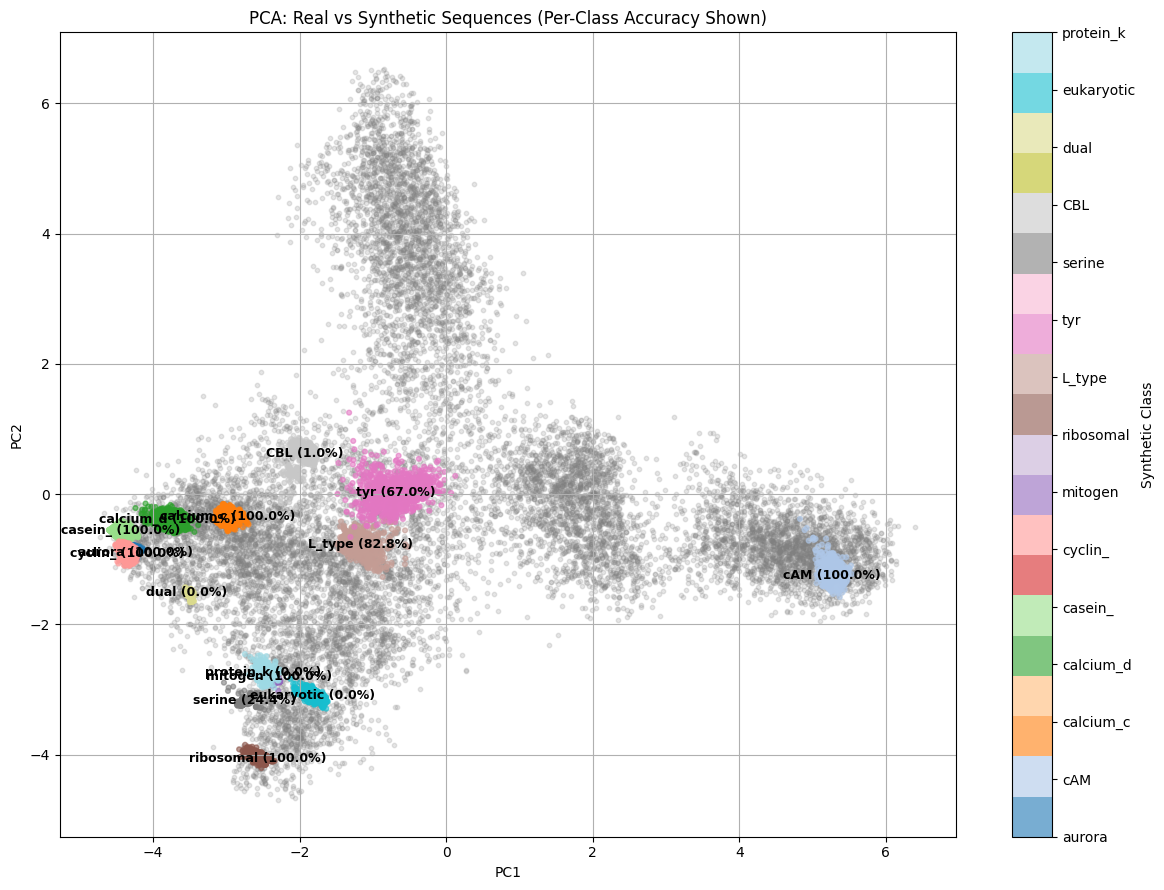

In [55]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# Load synthetic data and predictions
data = np.load('vae_generated_testseed_15class_1000each/synthetic_15k_sequences_byclass.npz')
X_syn = data['X']
y_syn = data['y']

# These should be the same as used in training/testing
unique_labels = [
    "aurora",
    "cAM",
    "calcium_c",
    "calcium_d",
    "casein_",
    "cyclin_",
    "mitogen",
    "ribosomal",
    "L_type",
    "tyr",
    "serine",
    "CBL",
    "dual",
    "eukaryotic",
    "protein_k"
]

# Per-class performance (same order as above)
accuracies = [
    1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000,
    0.828, 0.670, 0.244, 0.010, 0.000, 0.000, 0.000
]

# PCA already computed:
# X_real_pca, X_syn_pca, y_syn

# Plot
plt.figure(figsize=(12, 9))
plt.scatter(X_real_pca[:, 0], X_real_pca[:, 1], alpha=0.2, s=10, c='gray', label='Real (15k)')

# Plot synthetic, colored by class
scatter = plt.scatter(X_syn_pca[:, 0], X_syn_pca[:, 1], c=y_syn, cmap='tab20', s=12, alpha=0.6)

# Colorbar with labels
cbar = plt.colorbar(scatter, ticks=range(15))
cbar.ax.set_yticklabels(unique_labels)
cbar.set_label("Synthetic Class")

# Annotate each class's centroid with accuracy
for class_id in range(15):
    idx = y_syn == class_id
    if np.sum(idx) == 0:
        continue
    x_mean = X_syn_pca[idx, 0].mean()
    y_mean = X_syn_pca[idx, 1].mean()
    label = f"{unique_labels[class_id]} ({accuracies[class_id]*100:.1f}%)"
    plt.text(x_mean, y_mean, label, fontsize=9, ha='center', va='center', weight='bold', color='black')

plt.title("PCA: Real vs Synthetic Sequences (Per-Class Accuracy Shown)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()


now lets test the data

In [38]:
# Get class probabilities and predicted classes
y_probs = model.predict(X_syn)
y_pred = np.argmax(y_probs, axis=1)
from sklearn.metrics import accuracy_score
print(f"Accuracy on synthetic test set: {accuracy_score(y_syn, y_pred):.4f}")
from sklearn.metrics import classification_report

# Assuming you have the label names:
# unique_labels = ['AGC', 'CAMK', ..., 'TK']  (in same order as class indices)
print(classification_report(y_syn, y_pred, target_names=unique_labels))


469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 69ms/step
Accuracy on synthetic test set: 0.6501
                                                  precision    recall  f1-score   support

                 CBL_interacting_protein_kinases       1.00      0.01      0.02      1000
                           L_type_lectin_kinases       1.00      0.83      0.91      1000
                                  aurora_kinases       1.00      1.00      1.00      1000
                  cAMP_dependent_protein_kinases       1.00      1.00      1.00      1000
            calcium_calmodulin_dependent_kinases       0.79      1.00      0.88      1000
                       calcium_dependent_kinases       1.00      1.00      1.00      1000
                                  casein_kinases       1.00      1.00      1.00      1000
                        cyclin_dependent_kinases       0.57      1.00      0.73      1000
                dual_specificity_protein_kinases       0.00      0.00      0.00      1000
eukaryotic_transl

c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


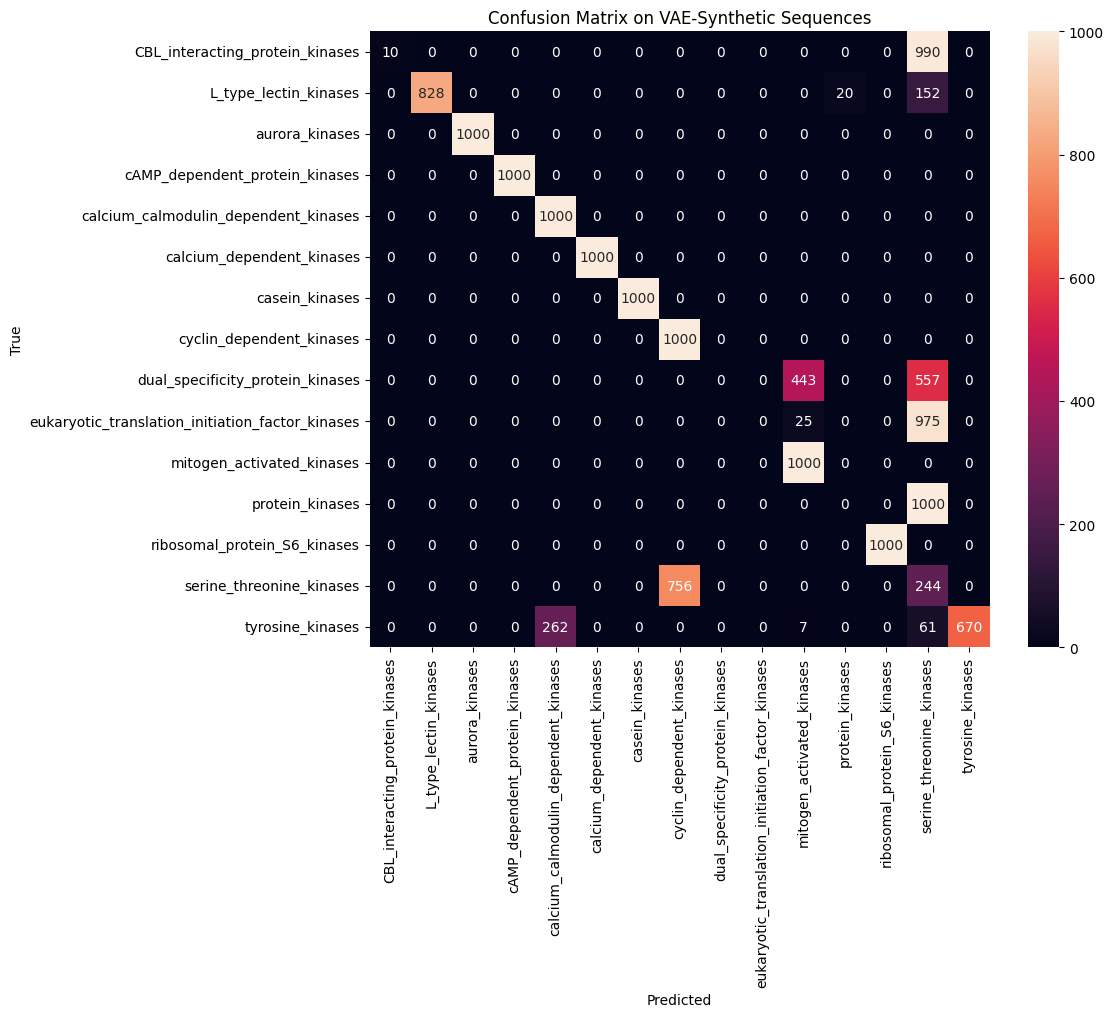

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_syn, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix on VAE-Synthetic Sequences")
plt.show()


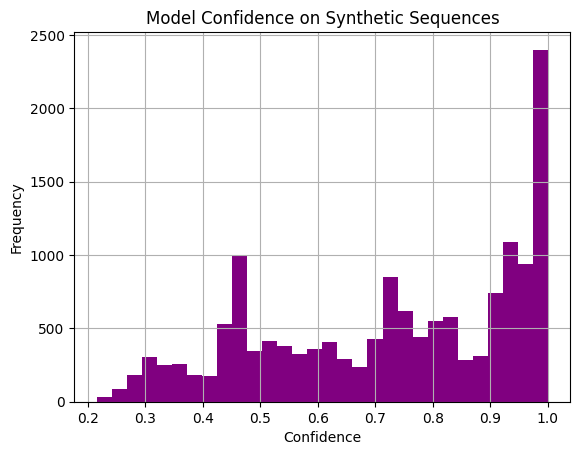

In [41]:
import matplotlib.pyplot as plt

confidences = np.max(y_probs, axis=1)
plt.hist(confidences, bins=30, color='purple')
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.title("Model Confidence on Synthetic Sequences")
plt.grid(True)
plt.show()


In [42]:
import pandas as pd

per_class_acc = {}
for i, label in enumerate(unique_labels):
    idx = (y_syn == i)
    acc = np.mean(y_pred[idx] == y_syn[idx])
    per_class_acc[label] = acc

df = pd.DataFrame.from_dict(per_class_acc, orient='index', columns=['Accuracy'])
df.sort_values('Accuracy', ascending=False, inplace=True)
print(df)


                                                  Accuracy
aurora_kinases                                       1.000
cAMP_dependent_protein_kinases                       1.000
calcium_calmodulin_dependent_kinases                 1.000
calcium_dependent_kinases                            1.000
casein_kinases                                       1.000
cyclin_dependent_kinases                             1.000
mitogen_activated_kinases                            1.000
ribosomal_protein_S6_kinases                         1.000
L_type_lectin_kinases                                0.828
tyrosine_kinases                                     0.670
serine_threonine_kinases                             0.244
CBL_interacting_protein_kinases                      0.010
dual_specificity_protein_kinases                     0.000
eukaryotic_translation_initiation_factor_kinases     0.000
protein_kinases                                      0.000


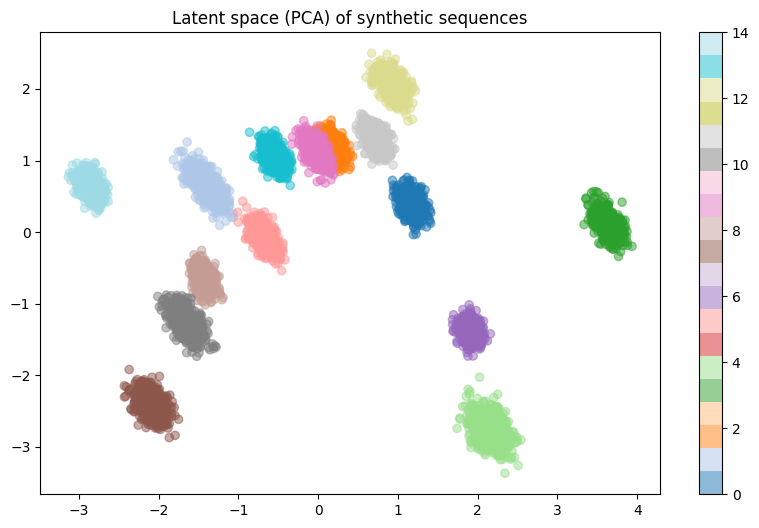

In [46]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Project synthetic latent vectors
z_all = []
labels = []
for class_id in range(15):
    base_seq = random.choice(samples_by_class[class_id])
    z_mean, z_log_var, _ = vae.encode(base_seq[np.newaxis, :])
    epsilon = np.random.normal(size=(500, vae.latent_dim))
    z_samples = z_mean.numpy()[0] + np.exp(0.5 * z_log_var.numpy()[0]) * epsilon
    z_all.append(z_samples)
    labels.extend([class_id] * 500)

z_all = np.vstack(z_all)
pca = PCA(n_components=2)
z_proj = pca.fit_transform(z_all)

plt.figure(figsize=(10, 6))
plt.scatter(z_proj[:, 0], z_proj[:, 1], c=labels, cmap='tab20', alpha=0.5)
plt.title("Latent space (PCA) of synthetic sequences")
plt.colorbar()
plt.show()


Prediction with confidence threshold

In [43]:
confidence_threshold = 0.90

y_probs = model.predict(X_syn)
max_probs = np.max(y_probs, axis=1)
y_pred = np.argmax(y_probs, axis=1)

# Apply confidence threshold
y_pred_confident = np.where(max_probs >= confidence_threshold, y_pred, -1)  # -1 = uncertain

469/469 ━━━━━━━━━━━━━━━━━━━━ 28s 61ms/step


In [44]:
confident_idx = y_pred_confident != -1
acc = np.mean(y_pred_confident[confident_idx] == y_syn[confident_idx])
print(f"Accuracy on confident predictions: {acc:.4f}")
print(f"Fraction of predictions classified as 'uncertain': {(~confident_idx).mean():.2%}")


Accuracy on confident predictions: 0.9152
Fraction of predictions classified as 'uncertain': 66.19%


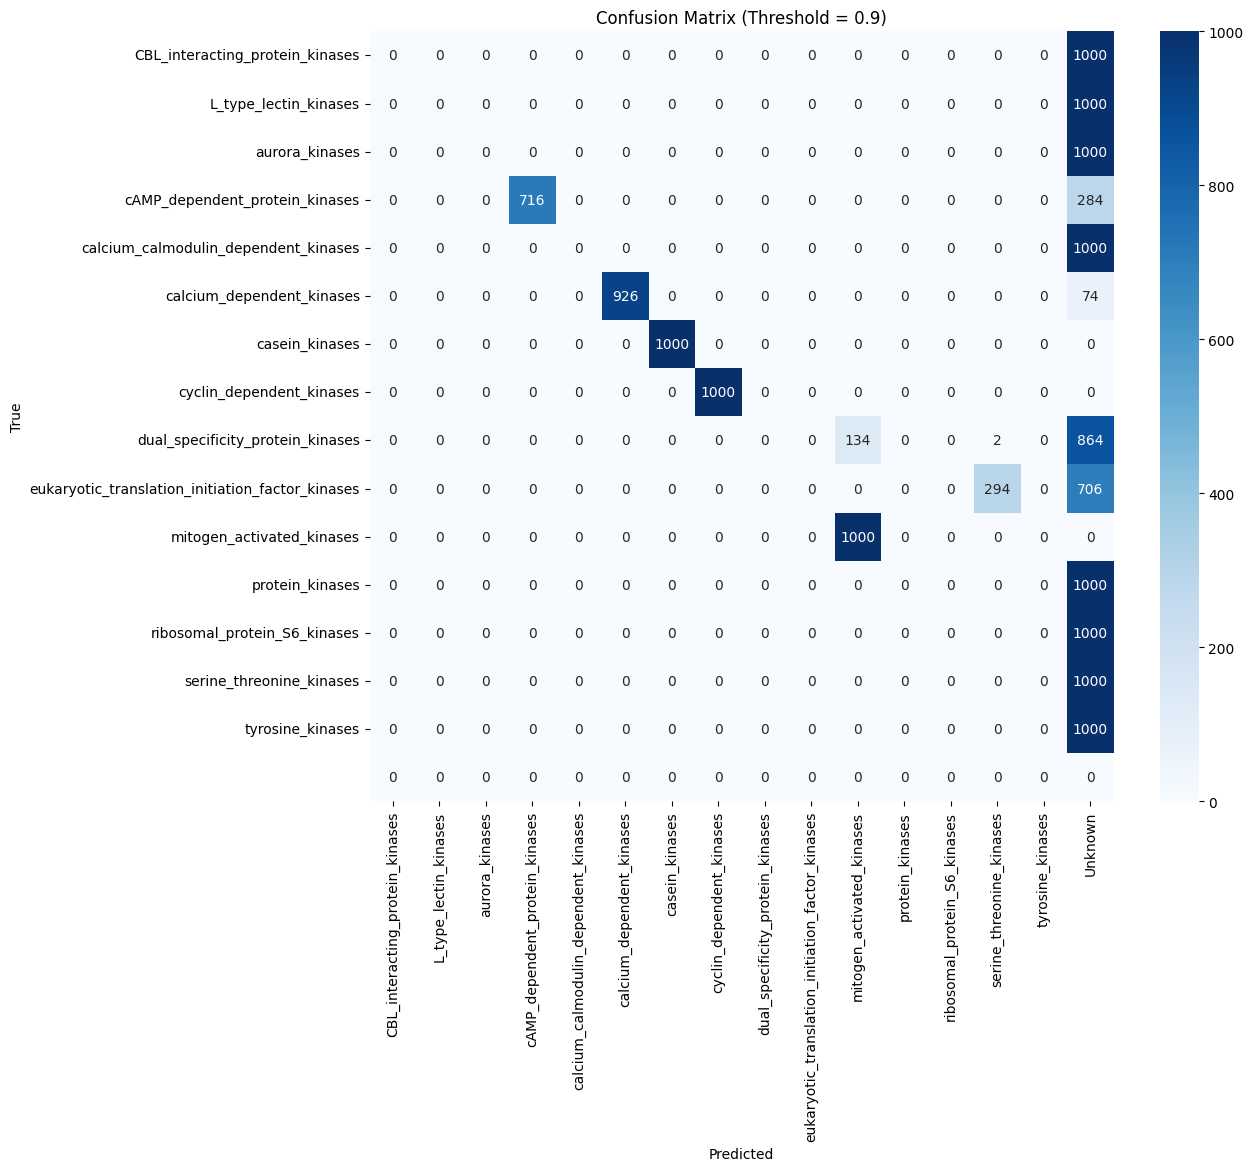

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

labels_with_unknown = unique_labels + ["Unknown"]
cm = confusion_matrix(y_syn, y_pred_confident, labels=list(range(15)) + [-1])

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_with_unknown, yticklabels=unique_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix (Threshold = {confidence_threshold})")
plt.show()


## lets test MLP_2 model on this test set 

In [57]:
import tensorflow as tf
from tensorflow.keras.models import load_model
# from your_module import Sampling, Encoder, Decoder, VAE  # if you need them

# 1) Re-load encoder
encoder = load_model(
    'vae_mlp_2 models/encoder_3d_to_32.keras',
    custom_objects={'Sampling': Sampling,
                    'Encoder': Encoder}
)

# 2) Re-load classifier
clf = load_model('vae_mlp_2 models/latent_mlp_classifier.keras')

"""
# 3) (Optional) Re-load full VAE
vae = load_model(
    'vae_mlp_2 models/protein_vae_model.keras',
    custom_objects={'Sampling': Sampling, 'Encoder': Encoder, 'Decoder': Decoder, 'VAE': VAE}
)
"""



c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\keras\src\layers\layer.py:396: UserWarning: `build()` was called on layer 'encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(



"\n# 3) (Optional) Re-load full VAE\nvae = load_model(\n    'vae_mlp_2 models/protein_vae_model.keras',\n    custom_objects={'Sampling': Sampling, 'Encoder': Encoder, 'Decoder': Decoder, 'VAE': VAE}\n)\n"

Embed the synthetic sequences

In [58]:
# Make sure encoder is loaded and frozen
encoder.trainable = False

# X_syn is shape (15000, 263, 21)
batch_size = 64
Z_syn = encoder.predict(X_syn, batch_size=batch_size, verbose=1)  # shape (15000, latent_dim)


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [59]:
y_probs_syn = clf.predict(Z_syn, batch_size=64, verbose=1)
y_pred_syn = np.argmax(y_probs_syn, axis=1)

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Latent MLP Accuracy on Synthetic Test Set: 0.8041
              precision    recall  f1-score   support

      aurora       1.00      1.00      1.00      1000
         cAM       1.00      1.00      1.00      1000
   calcium_c       1.00      1.00      1.00      1000
   calcium_d       1.00      0.06      0.12      1000
     casein_       1.00      1.00      1.00      1000
     cyclin_       1.00      1.00      1.00      1000
     mitogen       1.00      1.00      1.00      1000
   ribosomal       1.00      1.00      1.00      1000
      L_type       0.00      0.00      0.00      1000
         tyr       0.00      0.00      0.00      1000
      serine       0.50      1.00      0.67      1000
         CBL       1.00      1.00      1.00      1000
        dual       1.00      1.00      1.00      1000
  eukaryotic       0.34      1.00      0.51      1000
   protein_k       1.00      1.00      1.00      1000

    accuracy                           0.80     15000
   macro avg       0.79      0

c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


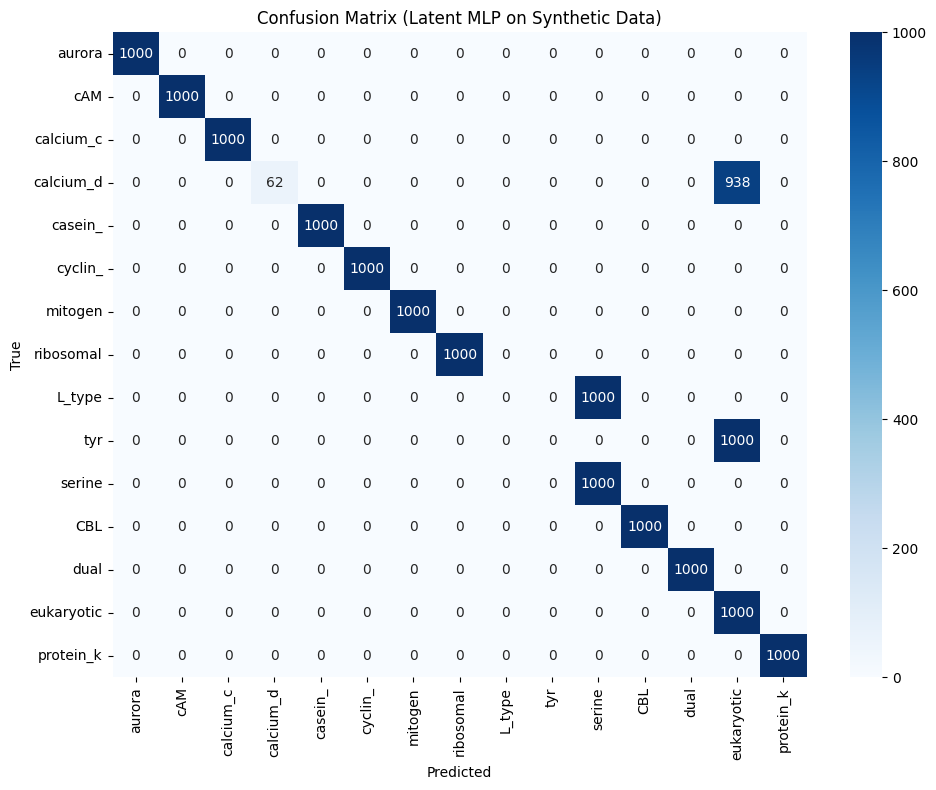

In [60]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# True labels from saved synthetic set
y_true_syn = data['y']

# Accuracy
acc = accuracy_score(y_true_syn, y_pred_syn)
print(f"Latent MLP Accuracy on Synthetic Test Set: {acc:.4f}")

# Classification report
print(classification_report(y_true_syn, y_pred_syn, target_names=unique_labels))

# Confusion matrix
cm = confusion_matrix(y_true_syn, y_pred_syn)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.title("Confusion Matrix (Latent MLP on Synthetic Data)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [61]:
import numpy as np
import pandas as pd

# y_true_syn: true class labels for synthetic sequences (shape: 15000,)
# y_pred_syn: predicted labels from your MLP classifier
# unique_labels: list of class names in index order (len = 15)

per_class_acc = {}

for i, label in enumerate(unique_labels):
    idx = (y_true_syn == i)
    total = np.sum(idx)
    correct = np.sum(y_pred_syn[idx] == i)
    acc = correct / total if total > 0 else 0
    per_class_acc[label] = acc

# Display as DataFrame
df = pd.DataFrame.from_dict(per_class_acc, orient='index', columns=['Accuracy'])
df = df.sort_values('Accuracy', ascending=False)
print(df)


            Accuracy
aurora         1.000
cAM            1.000
calcium_c      1.000
casein_        1.000
cyclin_        1.000
mitogen        1.000
ribosomal      1.000
serine         1.000
CBL            1.000
dual           1.000
eukaryotic     1.000
protein_k      1.000
calcium_d      0.062
L_type         0.000
tyr            0.000


### making 1000 sequence from labeled test dada to agument each class to 1000 each

In [62]:
from collections import defaultdict
import numpy as np

# Parameters
target_per_class = 1000
latent_dim = vae.latent_dim
batch_size = 64

# Group real test sequences by class
samples_by_class = defaultdict(list)
for x, y in zip(X_test, y_test):
    samples_by_class[y].append(x.reshape(-1))  # flatten to (5523,)

synthetic_X = []
synthetic_y = []

# Augment per class
for class_id, seqs in samples_by_class.items():
    n_real = len(seqs)
    if n_real == 0:
        continue
    n_per_real = int(np.ceil(target_per_class / n_real))

    print(f"Class {class_id}: {n_real} real samples -> {n_per_real} synthetic per real sample")

    for seq in seqs:
        seq = seq[np.newaxis, :]  # shape (1, 5523)
        z_mean, z_log_var, _ = vae.encode(seq)
        z_mean = z_mean.numpy()[0]
        z_log_var = z_log_var.numpy()[0]

        epsilon = np.random.normal(size=(n_per_real, latent_dim))
        z_samples = z_mean + np.exp(0.5 * z_log_var) * epsilon
        recon_flat = vae.decode(z_samples).numpy()
        X_prob = recon_flat.reshape(n_per_real, 263, 21)

        # Convert probabilities to one-hot encoded sequences
        onehot = np.zeros_like(X_prob)
        onehot[np.arange(n_per_real)[:, None], np.arange(263), np.argmax(X_prob, axis=2)] = 1

        synthetic_X.append(onehot)
        synthetic_y.extend([class_id] * n_per_real)

# Stack everything
X_augmented = np.vstack(synthetic_X)  # shape (?, 263, 21)
y_augmented = np.array(synthetic_y)   # shape (?)

# Now clip exactly 1000 per class
X_final = []
y_final = []
for class_id in range(15):
    idx = np.where(y_augmented == class_id)[0]
    idx = idx[:target_per_class]
    X_final.append(X_augmented[idx])
    y_final.append(np.full(target_per_class, class_id))

X_final = np.vstack(X_final)  # (15000, 263, 21)
y_final = np.hstack(y_final)  # (15000,)

print("Final synthetic test set shape:", X_final.shape, y_final.shape)


Class 13: 189 real samples -> 6 synthetic per real sample
Class 10: 51 real samples -> 20 synthetic per real sample
Class 7: 35 real samples -> 29 synthetic per real sample
Class 4: 7 real samples -> 143 synthetic per real sample
Class 2: 6 real samples -> 167 synthetic per real sample
Class 3: 5 real samples -> 200 synthetic per real sample
Class 11: 16 real samples -> 63 synthetic per real sample
Class 5: 16 real samples -> 63 synthetic per real sample
Class 0: 6 real samples -> 167 synthetic per real sample
Class 12: 5 real samples -> 200 synthetic per real sample
Class 6: 6 real samples -> 167 synthetic per real sample
Class 8: 3 real samples -> 334 synthetic per real sample
Class 9: 2 real samples -> 500 synthetic per real sample
Class 1: 2 real samples -> 500 synthetic per real sample
Class 14: 3 real samples -> 334 synthetic per real sample
Final synthetic test set shape: (15000, 263, 21) (15000,)


#### Testing biLSTM

In [64]:
# Predict using your LSTM classifier
y_probs_lstm = model.predict(X_final, batch_size=64)
y_pred_lstm = np.argmax(y_probs_lstm, axis=1)


235/235 ━━━━━━━━━━━━━━━━━━━━ 28s 118ms/step


In [65]:

# LSTM model accuracy
acc_lstm = accuracy_score(y_final, y_pred_lstm)
print(f"LSTM model accuracy on augmented test set: {acc_lstm:.4f}")


LSTM model accuracy on augmented test set: 0.6557


In [66]:
# LSTM model
print("LSTM model detailed report:")
print(classification_report(y_final, y_pred_lstm, target_names=unique_labels))

LSTM model detailed report:
              precision    recall  f1-score   support

      aurora       0.94      0.41      0.57      1000
         cAM       1.00      0.88      0.94      1000
   calcium_c       0.99      0.99      0.99      1000
   calcium_d       1.00      1.00      1.00      1000
     casein_       0.88      0.87      0.87      1000
     cyclin_       1.00      0.92      0.96      1000
     mitogen       0.99      0.96      0.98      1000
   ribosomal       0.96      0.86      0.91      1000
      L_type       1.00      0.12      0.21      1000
         tyr       0.00      0.00      0.00      1000
      serine       0.77      0.95      0.85      1000
         CBL       0.65      0.41      0.51      1000
        dual       1.00      0.40      0.57      1000
  eukaryotic       0.16      0.86      0.27      1000
   protein_k       0.98      0.20      0.34      1000

    accuracy                           0.66     15000
   macro avg       0.82      0.66      0.66     1500

c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [67]:
def per_class_accuracy(y_true, y_pred, labels):
    acc = {}
    for i, label in enumerate(labels):
        idx = (y_true == i)
        correct = np.sum(y_pred[idx] == i)
        total = np.sum(idx)
        acc[label] = correct / total if total > 0 else 0
    return pd.DataFrame.from_dict(acc, orient='index', columns=['Accuracy']).sort_values('Accuracy', ascending=False)

# LSTM per-class accuracy
print("\nLSTM model per-class accuracy:")
print(per_class_accuracy(y_final, y_pred_lstm, unique_labels))


LSTM model per-class accuracy:
            Accuracy
calcium_d      0.999
calcium_c      0.994
mitogen        0.958
serine         0.954
cyclin_        0.919
cAM            0.884
casein_        0.866
ribosomal      0.863
eukaryotic     0.860
CBL            0.414
aurora         0.405
dual           0.400
protein_k      0.205
L_type         0.115
tyr            0.000


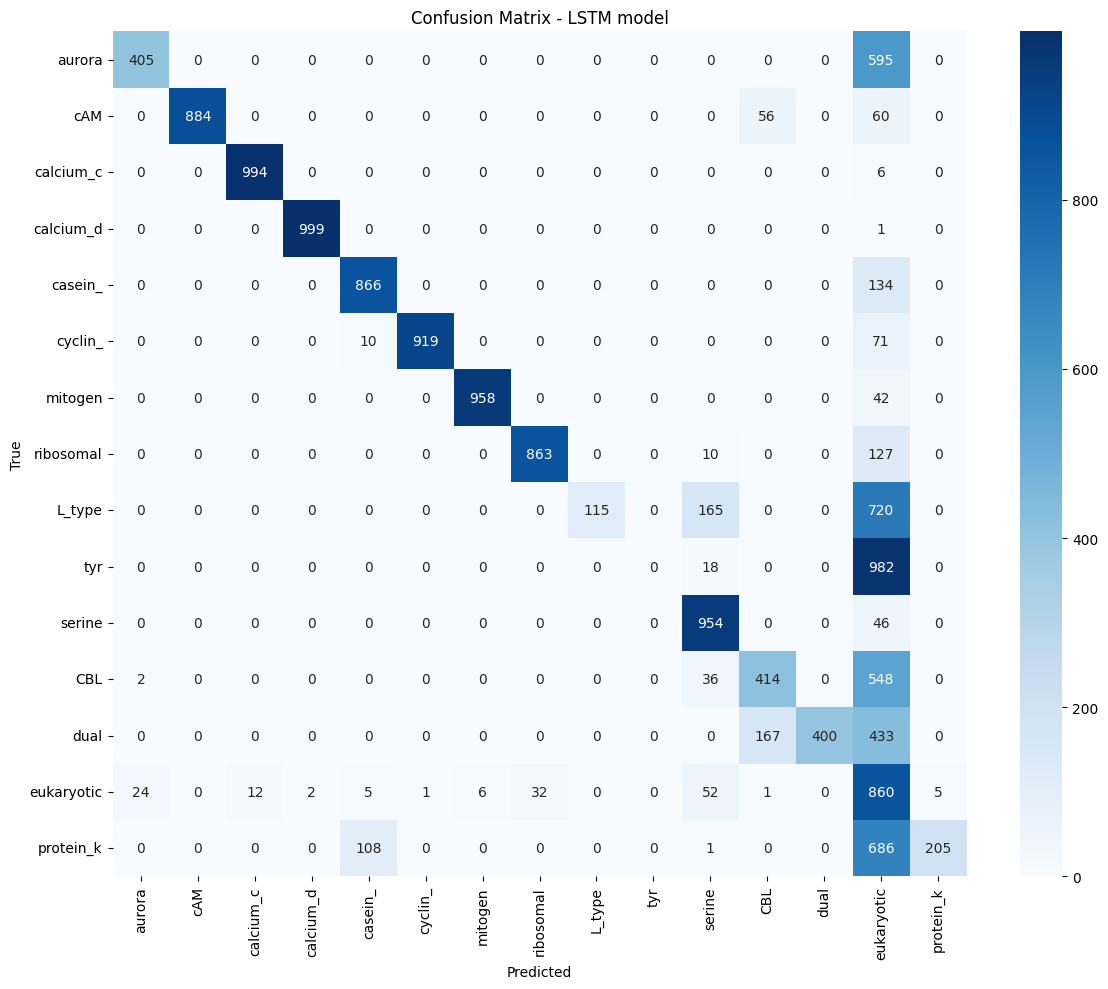

In [68]:
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=unique_labels, yticklabels=unique_labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

# LSTM Confusion
plot_confusion(y_final, y_pred_lstm, "Confusion Matrix - LSTM model")

#### test vae_mlp model

In [69]:
# First encode with VAE encoder
Z_final = encoder.predict(X_final, batch_size=batch_size)
# Then predict
y_probs_mlp = clf.predict(Z_final, batch_size=batch_size)
y_pred_mlp = np.argmax(y_probs_mlp, axis=1)


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [70]:
# MLP model accuracy
acc_mlp = accuracy_score(y_final, y_pred_mlp)
print(f"Latent MLP model accuracy on augmented test set: {acc_mlp:.4f}")

Latent MLP model accuracy on augmented test set: 0.7017


In [71]:
# MLP model
print("Latent MLP model detailed report:")
print(classification_report(y_final, y_pred_mlp, target_names=unique_labels))

Latent MLP model detailed report:
              precision    recall  f1-score   support

      aurora       0.97      0.64      0.77      1000
         cAM       1.00      1.00      1.00      1000
   calcium_c       0.99      1.00      1.00      1000
   calcium_d       1.00      0.62      0.76      1000
     casein_       1.00      0.86      0.92      1000
     cyclin_       1.00      0.92      0.96      1000
     mitogen       0.99      0.67      0.80      1000
   ribosomal       0.93      0.97      0.95      1000
      L_type       0.00      0.00      0.00      1000
         tyr       0.00      0.00      0.00      1000
      serine       0.59      0.96      0.73      1000
         CBL       0.98      0.57      0.72      1000
        dual       1.00      0.40      0.57      1000
  eukaryotic       0.20      0.92      0.33      1000
   protein_k       1.00      1.00      1.00      1000

    accuracy                           0.70     15000
   macro avg       0.78      0.70      0.70   

c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [72]:
# MLP per-class accuracy
print("\nLatent MLP model per-class accuracy:")
print(per_class_accuracy(y_final, y_pred_mlp, unique_labels))


Latent MLP model per-class accuracy:
            Accuracy
cAM            1.000
calcium_c      1.000
protein_k      1.000
ribosomal      0.971
serine         0.960
eukaryotic     0.921
cyclin_        0.920
casein_        0.858
mitogen        0.668
aurora         0.643
calcium_d      0.619
CBL            0.566
dual           0.400
L_type         0.000
tyr            0.000


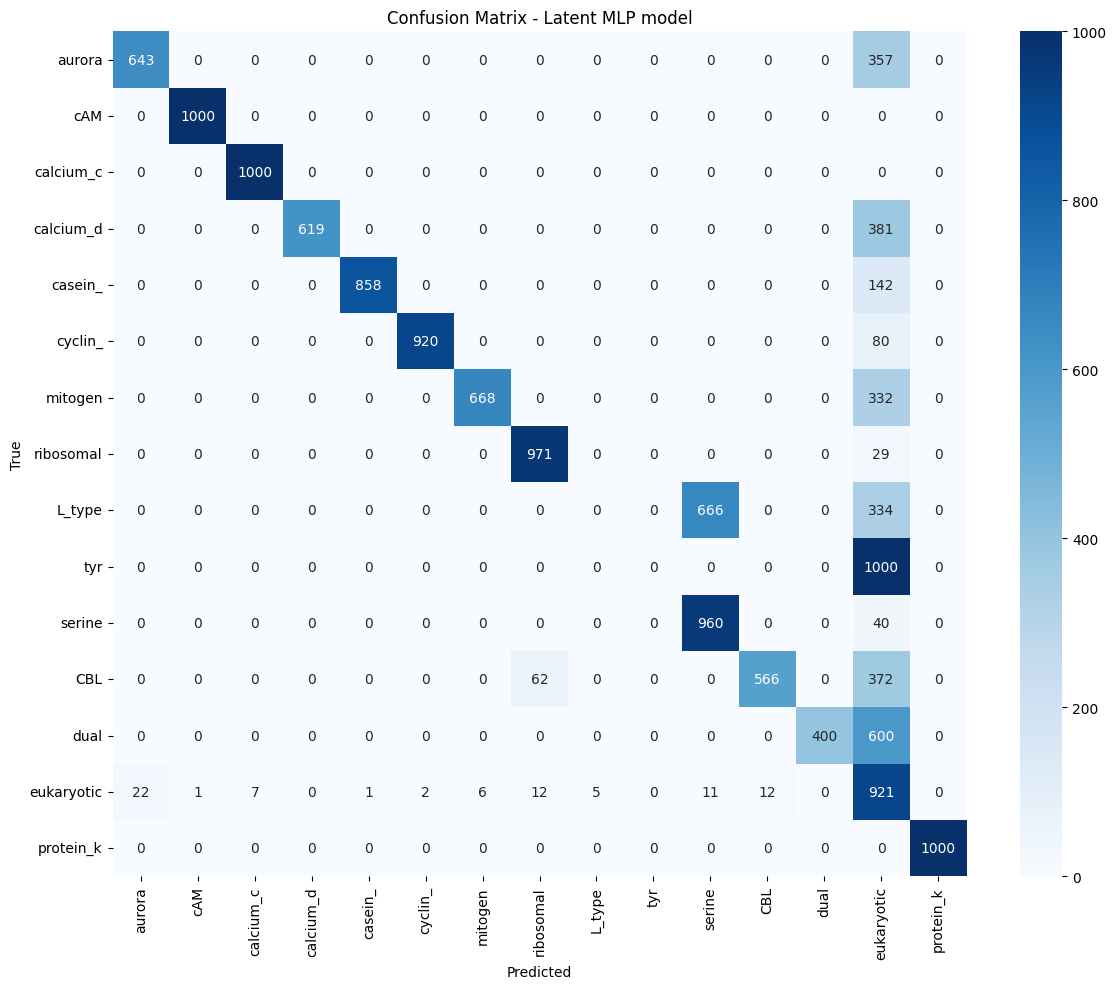

In [73]:
# MLP Confusion
plot_confusion(y_final, y_pred_mlp, "Confusion Matrix - Latent MLP model")